# Convolutional Neural Networks - Image Classification [using Pytorch]

### 1. INITIALIZATION

In [1]:
# Import necessary libraries and modules
import matplotlib.pyplot as plt
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

In [2]:
# Check tensorflow version
torch.__version__

'2.3.1+cu121'

### 2. LOADING & TRANSFORMING DATASET

The dataset used is [CIFAR-10](https://www.cs.toronto.edu/~kriz/cifar.html), which is a widely used benchmark dataset in the field of computer vision and machine learning.

It consists of 60,000 32x32 color images in 10 classes, with 6,000 images per class. It serves as a standard dataset for training and evaluating machine learning algorithms, particularly for image classification tasks.

The classes are: airplane, automobile, bird, cat, deer, dog, frog, horse, ship, and truck.

Before loading the dataset, we need to initialize data augmentation and image transformations to avoid overfitting. This helps to increase the diversity of the dataset and improve the generalization ability of the CNN model.

Transformations of training images are:

- Randomly rotate images
- Randomly flip images horizontally
- Randomly changing the brightness, contrast, saturation, and hue of the image (color jitter)
- Scale the pixel values of the images to be in the range [0, 1] (automatically done when converting to tensor)

In [3]:
# Creating transformer for training data as a series of steps
transform_train = transforms.Compose([
    transforms.RandomRotation(10),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [4]:
# Creating transformer for testing data as a series of steps - without augmentation
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

By separating the transformation pipelines for training and testing, we ensure that the model is trained with data augmentations that help it generalize better, while the test data remains consistent and unmodified to accurately evaluate the model's performance.

In [5]:
# Loading the dataset from pytorch library
data_train = torchvision.datasets.CIFAR10(root="./data/raw", train=True, download=True, transform=transform_train)
data_test = torchvision.datasets.CIFAR10(root="./data/raw", train=False, download=True, transform=transform_test)

100%|██████████| 170498071/170498071 [00:05<00:00, 30007598.45it/s]


Extracting ./data/raw/cifar-10-python.tar.gz to ./data/raw
Files already downloaded and verified


In [6]:
# Initialize data loaders
train_loader = torch.utils.data.DataLoader(data_train, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(data_test, batch_size=32, shuffle=False)

### 3. BUILDING CNN MODEL

In [7]:
class CNN(nn.Module):
    def __init__(self):

        super(CNN, self).__init__()

        # Define the convolutional layers
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)

        # Define the pooling layers
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)

        # Define the fully connected layers
        self.fc1 = nn.Linear(64 * 8 * 8, 128)  # 8 * 8 * 64 is the flattened dimension after pooling
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)  # 10 output units for 10 classes

    def forward(self, x):

        # Apply convolutional layers with ReLU activation and pooling
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))

        # Flatten the output from the convolutional layers
        x = x.view(-1, 64 * 8 * 8)

        # Apply fully connected layers with ReLU activation
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))

        # Apply the output layer with softmax activation
        x = self.fc3(x)
        return F.log_softmax(x, dim=1)

In [8]:
# Initialize the model
cnn = CNN()

# Define the loss function (cross-entropy loss)
criterion = nn.CrossEntropyLoss()

# Define the optimizer (Adam optimizer)
optimizer = torch.optim.Adam(cnn.parameters(), lr=0.001)

### 4. TRAINING CNN MODEL

In [9]:
# Initialize metrics function
def compute_metrics(outputs, labels):
     # Convert model outputs to predicted labels
    _, preds = torch.max(outputs, 1)

    # Convert labels and predictions to numpy arrays
    labels = labels.cpu().numpy()
    preds = preds.cpu().numpy()

    # Calculate accuracy, F1-score, precision, and recall
    accuracy = accuracy_score(labels, preds)
    f1 = f1_score(labels, preds, average='weighted')
    precision = precision_score(labels, preds, average='weighted', zero_division=1)
    recall = recall_score(labels, preds, average='weighted', zero_division=1)

    return accuracy, f1, precision, recall

In [10]:
# Number of epochs to train the model
num_epochs = 25

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Move your model to the GPU
cnn.to(device)

# Set model to training mode
cnn.train()

# Lists to store training and validation metrics
train_accuracies = []
val_accuracies = []

# Training loop
for epoch in range(num_epochs):

    running_loss = 0.0
    running_accuracy = 0.0
    running_f1 = 0.0
    running_precision = 0.0
    running_recall = 0.0
    for i, (inputs, labels) in enumerate(train_loader):

         # Move inputs and labels to the GPU
        inputs, labels = inputs.to(device), labels.to(device)

        # Initialize parameter gradients
        optimizer.zero_grad()

        # Forward pass: compute model output
        outputs = cnn(inputs)

        # Compute loss
        loss = criterion(outputs, labels)

        # Backward pass: compute gradients
        loss.backward()

        # Update model parameters
        optimizer.step()

        # Accumulate loss
        running_loss += loss.item()

        # Calculate metrics
        accuracy, f1, precision, recall = compute_metrics(outputs, labels)
        running_accuracy += accuracy
        running_f1 += f1
        running_precision += precision
        running_recall += recall

    # Calculate average metrics for each epoch
    avg_loss = running_loss / len(train_loader)
    avg_accuracy = running_accuracy / len(train_loader)
    avg_f1 = running_f1 / len(train_loader)
    avg_precision = running_precision / len(train_loader)
    avg_recall = running_recall / len(train_loader)

    # Store training accuracy
    train_accuracies.append(avg_accuracy)

   # Set model to evaluation mode
    cnn.eval()

    # Initialize evaluation metrics
    eval_loss = 0.0
    eval_accuracy = 0.0
    eval_f1 = 0.0
    eval_precision = 0.0
    eval_recall = 0.0

    # Disable gradient computation for evaluation
    with torch.no_grad():
        for inputs, labels in test_loader:

            # Move inputs and labels to the GPU
            inputs, labels = inputs.to(device), labels.to(device)

            # Forward pass: compute model output
            outputs = cnn(inputs)

            # Compute loss
            loss = criterion(outputs, labels)

            # Accumulate evaluation loss
            eval_loss += loss.item()

            # Calculate metrics
            accuracy, f1, precision, recall = compute_metrics(outputs, labels)
            eval_accuracy += accuracy
            eval_f1 += f1
            eval_precision += precision
            eval_recall += recall

    # Calculate average metrics for the evaluation set for each epoch
    avg_eval_loss = eval_loss / len(test_loader)
    avg_eval_accuracy = eval_accuracy / len(test_loader)
    avg_eval_f1 = eval_f1 / len(test_loader)
    avg_eval_precision = eval_precision / len(test_loader)
    avg_eval_recall = eval_recall / len(test_loader)

    # Store validation accuracy
    val_accuracies.append(avg_eval_accuracy)

    # Print average metrics for the epoch
    print(f'Epoch [{epoch+1}/{num_epochs}], '
          f'accuracy: {avg_accuracy:.4f} - f1_score: {avg_f1:.4f} - loss: {avg_loss:.4f} - '
          f'precision: {avg_precision:.4f} - recall: {avg_recall:.4f} - '
          f'val_accuracy: {avg_eval_accuracy:.4f} - val_f1_score: {avg_eval_f1:.4f} - val_loss: {avg_eval_loss:.4f} - '
          f'val_precision: {avg_eval_precision:.4f} - val_recall: {avg_eval_recall:.4f}')

    # Set model back to training mode
    cnn.train()


Epoch [1/25], accuracy: 0.4637 - f1_score: 0.4484 - loss: 1.4709 - precision: 0.5974 - recall: 0.4637 - val_accuracy: 0.6051 - val_f1_score: 0.5960 - val_loss: 1.1105 - val_precision: 0.6873 - val_recall: 0.6051
Epoch [2/25], accuracy: 0.6109 - f1_score: 0.6058 - loss: 1.0967 - precision: 0.6962 - recall: 0.6109 - val_accuracy: 0.6662 - val_f1_score: 0.6608 - val_loss: 0.9599 - val_precision: 0.7430 - val_recall: 0.6662
Epoch [3/25], accuracy: 0.6580 - f1_score: 0.6541 - loss: 0.9707 - precision: 0.7338 - recall: 0.6580 - val_accuracy: 0.6872 - val_f1_score: 0.6858 - val_loss: 0.9096 - val_precision: 0.7578 - val_recall: 0.6872
Epoch [4/25], accuracy: 0.6846 - f1_score: 0.6815 - loss: 0.8977 - precision: 0.7559 - recall: 0.6846 - val_accuracy: 0.7050 - val_f1_score: 0.7000 - val_loss: 0.8525 - val_precision: 0.7681 - val_recall: 0.7050
Epoch [5/25], accuracy: 0.7048 - f1_score: 0.7024 - loss: 0.8418 - precision: 0.7738 - recall: 0.7048 - val_accuracy: 0.7255 - val_f1_score: 0.7209 - va

In [11]:
from torchsummary import summary

summary(cnn, (3, 128, 128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 128, 128]             896
         MaxPool2d-2           [-1, 32, 64, 64]               0
            Conv2d-3           [-1, 64, 64, 64]          18,496
         MaxPool2d-4           [-1, 64, 32, 32]               0
            Linear-5                  [-1, 128]         524,416
            Linear-6                   [-1, 64]           8,256
            Linear-7                   [-1, 10]             650
Total params: 552,714
Trainable params: 552,714
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.19
Forward/backward pass size (MB): 7.50
Params size (MB): 2.11
Estimated Total Size (MB): 9.80
----------------------------------------------------------------


### 5. PERFORMANCE ANALYSIS


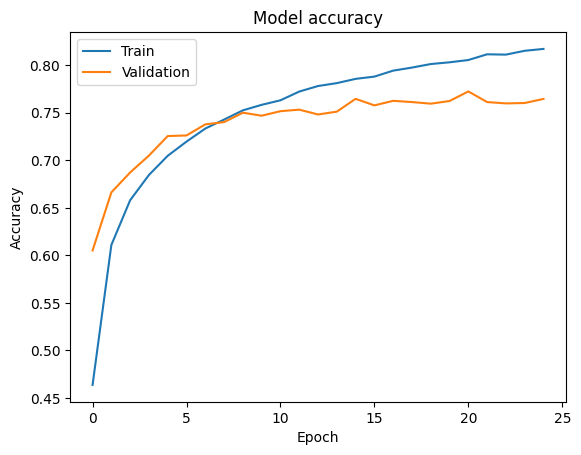

In [12]:
# Plot training & validation accuracy values
plt.plot(train_accuracies)
plt.plot(val_accuracies)
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

The results highlights the following points:
- The training accuracy steadily increases as the number of epochs increases. This indicates that the model is learning and improving its performance on the training data.
- The validation accuracy initially increases as the model learns more representations from the training data.
- However, after reaching a peak around the 9th epoch, the validation accuracy starts to fluctuate. This might indicate that the model is beginning to overfit, as it fails to generalize well to unseen data.
- The gap between training and validation accuracy starts to widen after a certain point, indicating increasing overfitting as training progresses.

In [ ]:
#way to reduce overfitting

#add more data
#data Augmentation
#L1/L2 Regularizer
#Drop out
#Batch norm
#Reduce complexity